### Análise da base de dados 'Beta' utilizando algoritmos de ML

Neste notebook será analisado o 'Beta Dataset' utilizando algoritmos de ML para realizar (1) extração de característocas; (2) seleção de características e (3) classificação dos dados.

#### Pontos importantes
- Frequências estimuladas (tota de 40, com a diferença de 0.2 Hz uma da outra): 8.9; 8.2, ...., 15.6, 15.8;
- Taxa de amostragem: 250Hz

#### Analisar os momentos em que ocorrem evocação do sinal SSVEP

1. Criar o objeto MNE a partir dos dados do participante;
2. Aplicar no objeto MNE o filtro passa-faixa nos valores de 6 a 18 Hz;
3. Criar cópias do objeto MNE (.copy()) com fatias de tempo menores para analisar momentos que ocorrem estímulos ou não (verificar artigo)´;
    - 0.0 - 0.5 segundos e 2.5 - 3.0 segundos ocorre apenas ruído;
    0.5 - 2.5 ocorre sinal SSVEP com ruído
4. Com os sinais separados em objeto MNE, aplicar a FFT para que seja possível plotar gráficos que contenham (ou não) as informações (obet os dados no domínio da frequência com get_data para que seja possível plotar os gráficos)
    - Os dados devem ser plotados no domínio da frequência após a transformada de Fourier. O FFT pode ser realizado pela biblioteca scipy.fft
    - Deve ser observado que as janelas 0.0 - 0.5s com ruído não aparecerão de fato o sinal SSVEP

#### Extração de características

Uma característica importante de acordo com o artigo base é o *signal-to-noise ratio* (SNR). Ao final desta etapa, será obtido um vetor de características. Estas podem ser:
- SNR (obrigatória)
- Maior valor espectral (FFT)
- Média dos valores espectrais (FFT)

Teremos um vetor de características de 64 x 3. Final (160, 64 + 64+ 64, 750)

Dimensionalidade dos dados será explicada da seguinte formada: 
40, 4, 64, 750 -> 40 targets, 4 trials, 64 canais e 750 valores
160, 64 (SNR) + 64 (média) + 64 (maior), ...

Resultando em 160, 192

#### Seleção de características
Como existem diversos eletrodos (canais) que não obtém sinal SSVEP, podemos extrair as características que não contribuem para a classificação dos dados. Podemos utilizar o método RFE (*Recursive Feature Elimination*), aplicado por meio de sklearn.feature_selecion.RFE, aprimorando o parâmetro n_features_to_select até obter o melhor resultado de classificação. Diminuir as features até o SVM dar o melhor resultado.

Para a classificação propriamente dita, é considerado o uso do SVM (o kernel só pode ser linear).

In [31]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [32]:
data = np.load("../datasets/beta/data.npy")
print(data.shape)

(160, 64, 750)


In [33]:
# criação de um objeto "info"
n_channels = 64
sfreq = 250
ch_names = ["FP1", "FPZ", "FP2", "AF3", "AF4", "F7", "F5", "F3", "F1", "FZ", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCZ", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "CZ", "C2", "C4", "C6", "T8", "M1", "TP7", "CP5", "CP3", "CP1", "CPZ", "CP2", "CP4", "CP6", "TP8", "M2", "P7", "P5", "P3", "P1", "PZ", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POZ", "PO4", "PO6", "PO8", "CB1", "O1", "OZ", "O2", "CB2"]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)

In [34]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../datasets/beta/labels.npy")
print(labels, labels.shape)

[ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8
  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6
 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4
 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2
  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.
 12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8
 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6
  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4
 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2
 15.4 15.6 15.8  8.   8.2  8.4] (160,)


In [35]:
# método para transformar labels categóricos
data_correct = data
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(160, dtype=int),
    le.fit_transform(labels))
)

event_dict = {str(value): index  for index, value in enumerate(sorted(set(labels)))}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
filtered_mne_data = mne_data.filter(6, 18)
filtered_mne_data

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 6 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    0.8s
[Parallel(n_job

Number of events,160
Events,10.0: 410.2: 410.4: 410.6: 410.8: 411.0: 411.2: 411.4: 411.6: 411.8: 412.0: 412.2: 412.4: 412.600000000000001: 412.8: 413.0: 413.200000000000001: 413.4: 413.600000000000001: 413.8: 414.0: 414.200000000000001: 414.4: 414.600000000000001: 414.8: 415.0: 415.200000000000001: 415.4: 415.600000000000001: 415.8: 48.0: 48.2: 48.4: 48.6: 48.799999999999999: 49.0: 49.2: 49.4: 49.6: 49.8: 4
Time range,0.000 – 2.996 s
Baseline,off


In [36]:
# cópias de fatias de tempo
tempo1 = filtered_mne_data.copy().crop(tmin=0.0, tmax=0.5)
tempo2 = filtered_mne_data.copy().crop(tmin=0.5, tmax=2.5)
tempo3 = filtered_mne_data.copy().crop(tmin=2.5, tmax=2.996)

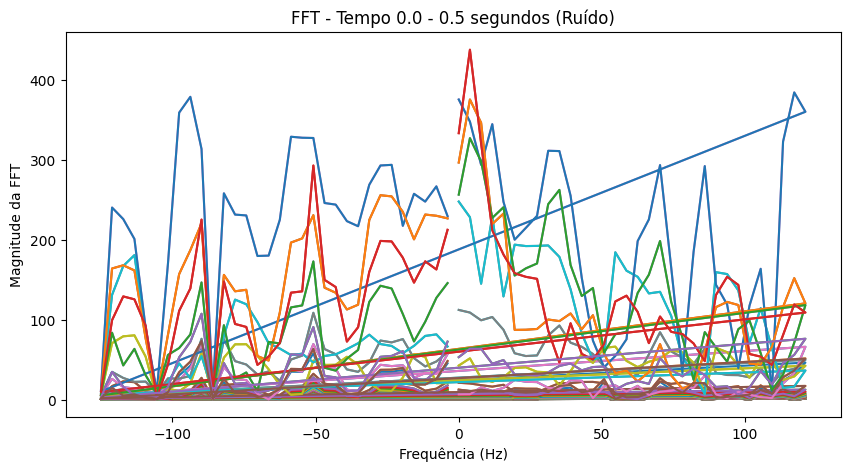

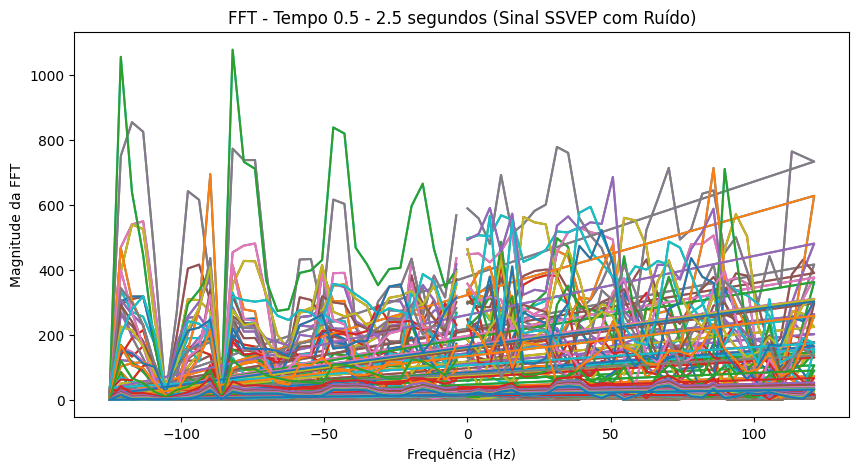

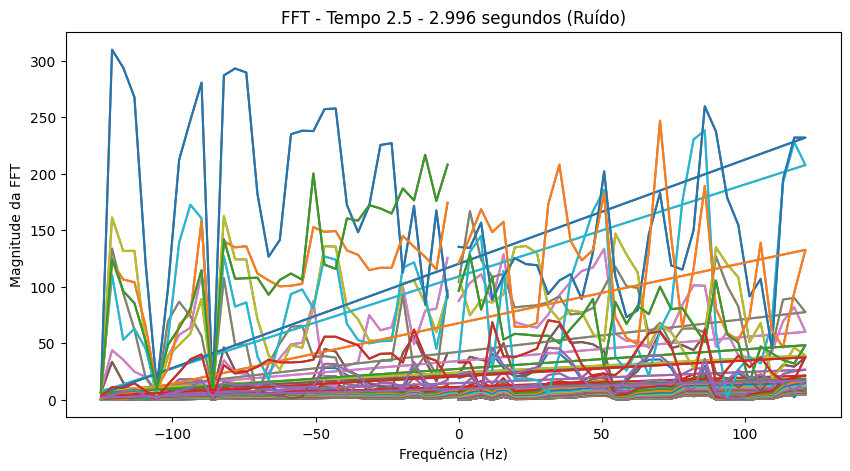

In [48]:
#CANAL 0

from scipy.fft import fft

# Crie uma função para calcular a FFT e plotar os gráficos
def calculate_and_plot_fft(data, title):
    signal = data.get_data()[0]  # Pegando o primeiro canal
    n_samples = len(signal)
    sample_rate = data.info['sfreq']
    
    # Calcule a FFT
    freqs = np.fft.fftfreq(n_samples, 1 / sample_rate)
    fft_values = fft(signal)
    fft_mag = np.abs(fft_values)
    
    # Plote os gráficos
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(freqs, fft_mag)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude da FFT')
    plt.show()

# Calcule e plote a FFT para cada cópia de fatia de tempo
calculate_and_plot_fft(tempo1, title="FFT - Tempo 0.0 - 0.5 segundos (Ruído)")
calculate_and_plot_fft(tempo2, title="FFT - Tempo 0.5 - 2.5 segundos (Sinal SSVEP com Ruído)")
calculate_and_plot_fft(tempo3, title="FFT - Tempo 2.5 - 2.996 segundos (Ruído)")


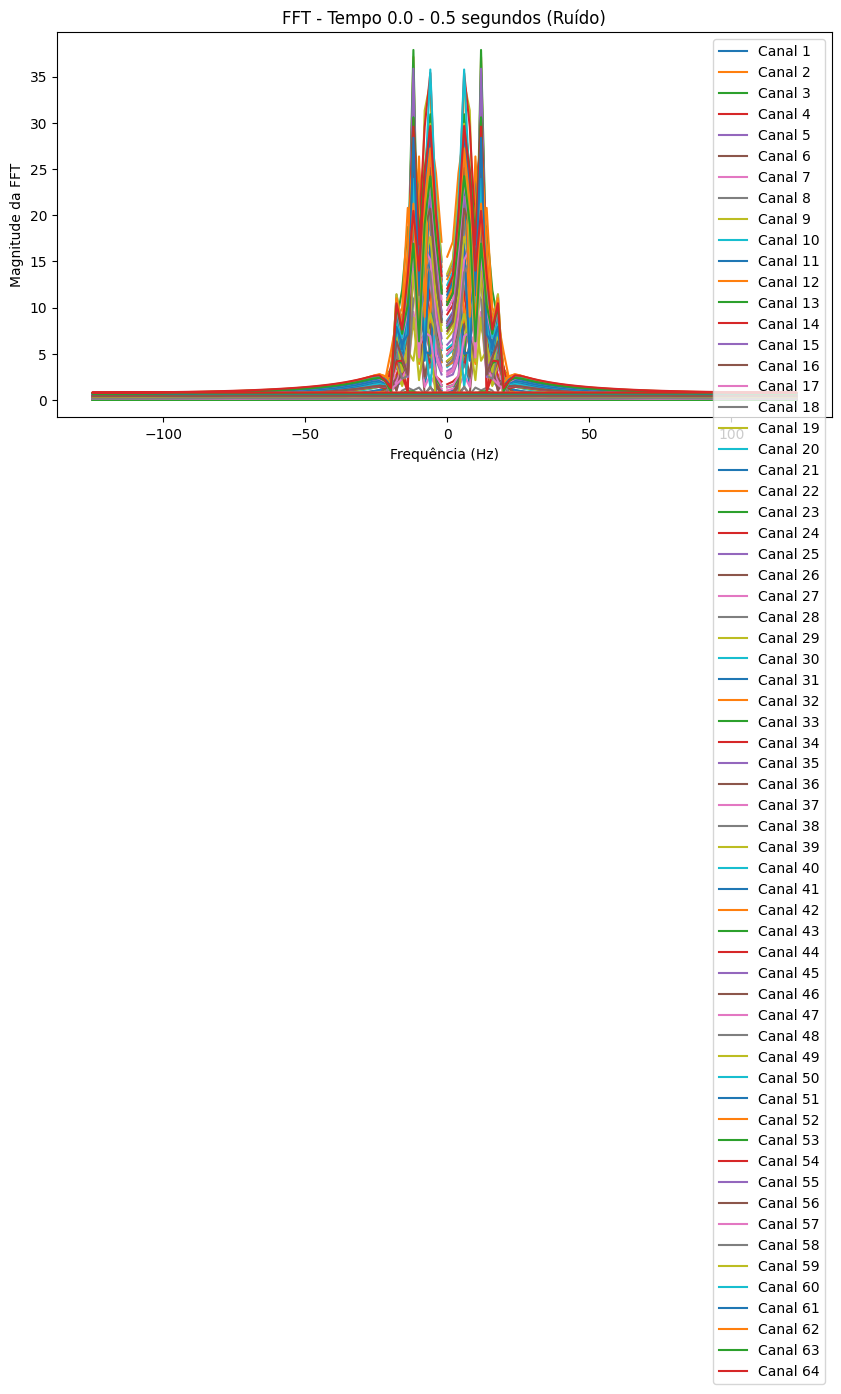

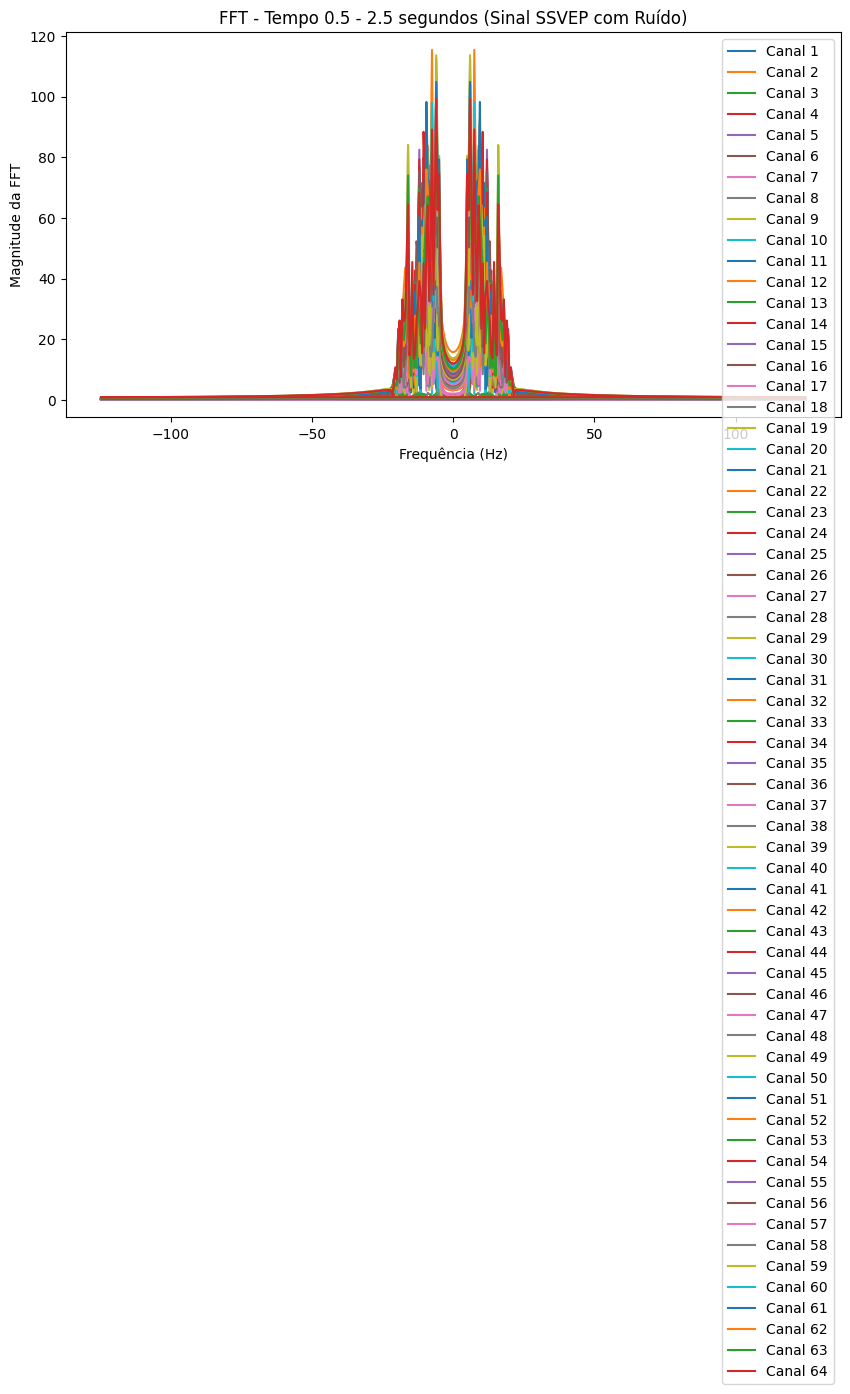

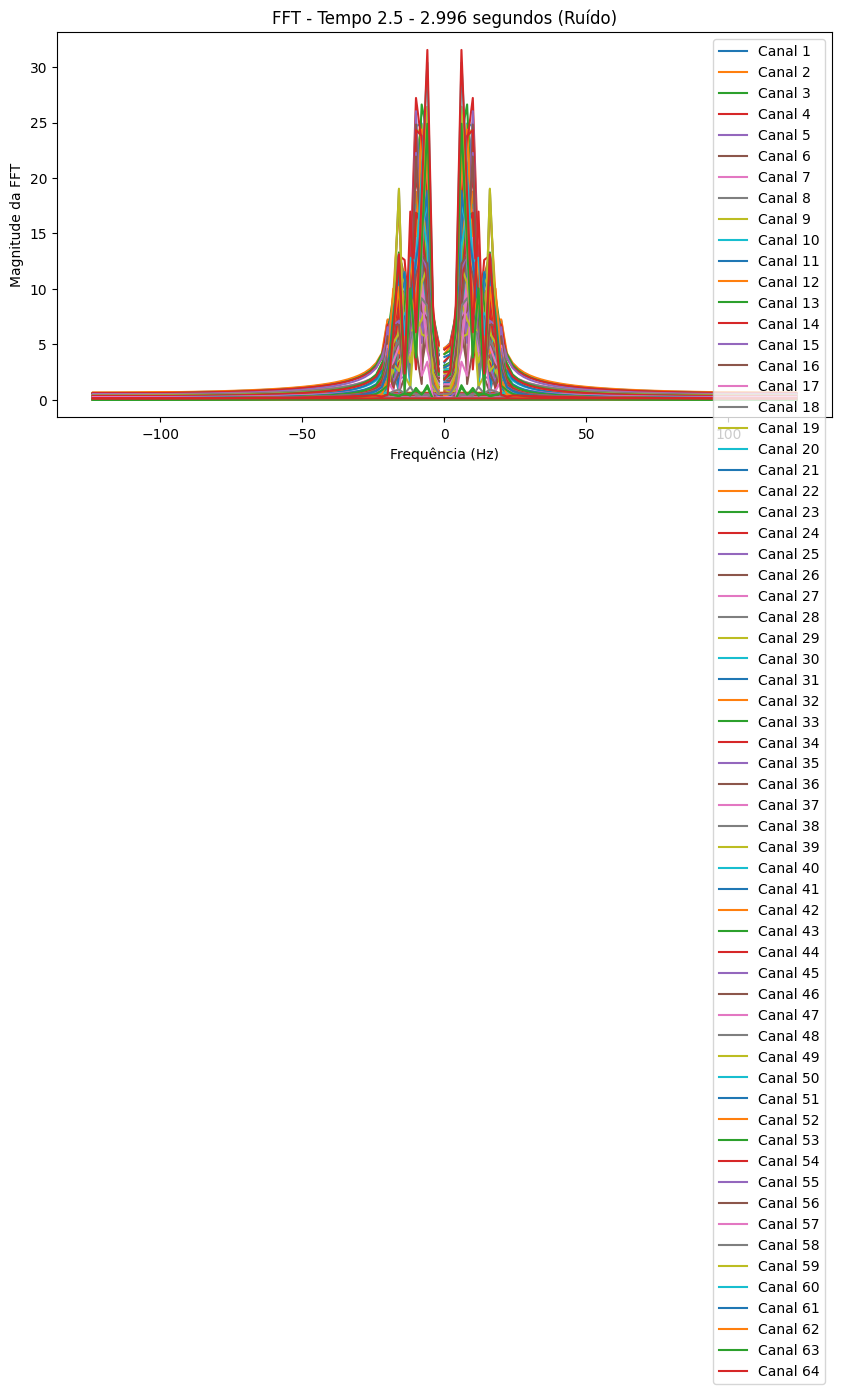

In [49]:
# 64 CANAIS

from scipy.fft import fft

# Crie uma função para calcular a FFT e plotar os gráficos para todos os canais
def calculate_and_plot_fft(data, title):
    data_array = data.get_data()
    n_epochs, n_channels, n_times = data_array.shape
    sample_rate = data.info['sfreq']

    # Calcule a FFT para cada canal
    plt.figure(figsize=(10, 5))
    plt.title(title)
    
    for i in range(n_channels):
        channel_data = data_array[:, i, :].mean(axis=0)  # Média dos canais em todas as épocas
        n_samples = len(channel_data)

        # Calcule a FFT
        freqs = np.fft.fftfreq(n_samples, 1 / sample_rate)
        fft_values = fft(channel_data)
        fft_mag = np.abs(fft_values)

        # Plote os gráficos para cada canal
        plt.plot(freqs, fft_mag, label=f'Canal {i + 1}')

    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude da FFT')
    plt.legend(loc='upper right')
    plt.show()

# Calcule e plote a FFT para cada cópia de fatia de tempo
calculate_and_plot_fft(tempo1, title="FFT - Tempo 0.0 - 0.5 segundos (Ruído)")
calculate_and_plot_fft(tempo2, title="FFT - Tempo 0.5 - 2.5 segundos (Sinal SSVEP com Ruído)")
calculate_and_plot_fft(tempo3, title="FFT - Tempo 2.5 - 2.996 segundos (Ruído)")
